In [1]:
import torch

import os
# os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl
# import math

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [2]:
def get_cuda_autotune_config():
    configs = []
    for num_warps, num_stages in [
        (4, 2),
        (4, 3),
        (4, 4),
        # (8, 2),
        # (8, 4),
    ]:
        for GROUP_SIZE_M in [1, 4, 8, 128]:
            for BLOCK_SIZE_M in [16]:
                for BLOCK_SIZE_N in [32, 64, 128]:
                    for BLOCK_SIZE_K in [32, 64, 128, 256]:
                        configs.append(
                            triton.Config(
                                {
                                    "GROUP_SIZE_M" : GROUP_SIZE_M,
                                    "BLOCK_SIZE_M" : BLOCK_SIZE_M,
                                    "BLOCK_SIZE_N" : BLOCK_SIZE_N,
                                    "BLOCK_SIZE_K" : BLOCK_SIZE_K,
                                }, 
                                num_stages=num_stages, 
                                num_warps=num_warps
                            ),
                        )                        
    return configs
    # return [triton.Config(
    #                             {
    #                                 "GROUP_SIZE_M" : 1,
    #                                 "BLOCK_SIZE_M" : 32,
    #                                 "BLOCK_SIZE_N" : 64,
    #                                 "BLOCK_SIZE_K" : 64,
    #                             },
    #                             num_stages=4,
    #                             num_warps=4
    #                         )]


In [3]:
@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_w4a16(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    # tl.assume(pid_m == 1)

    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bk = tl.arange(0, BLOCK_SIZE_K // 8)
    offs_bn = (pid_n * (BLOCK_SIZE_N) + tl.arange(0, BLOCK_SIZE_N)) % N
    b_ptrs = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn[None, :] * stride_bn)

    shifter = tl.arange(0, 8) * 4

    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)

    a_mask0 = (offs_am[:, None] < M) & (offs_k[None, :] < K)
    b_mask0 = (offs_bn[None, :] < N) & ((offs_bk[:, None]) < K // 8)
    a = tl.load(a_ptrs, mask=a_mask0, other=0.0)#, eviction_policy="evict_last")
    b_bits = tl.load(b_ptrs, mask=b_mask0, other=0)#, eviction_policy="evict_first")
    for k_idx in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        next_k_offset = (k_idx + 1) * BLOCK_SIZE_K
        
        if k_idx + 1 < tl.cdiv(K, BLOCK_SIZE_K):
            a_next_mask = (offs_am[:, None] < M) & (offs_k[None, :] + next_k_offset < K)
            b_next_mask = (offs_bn[None, :] < N) & ((offs_bk[:, None] + (next_k_offset // 8)) < K // 8)
            a_next = tl.load(a_ptrs + next_k_offset * stride_ak, mask=a_next_mask, other=0.0)#, eviction_policy="evict_last")
            b_bits_next = tl.load(b_ptrs + (next_k_offset // 8) * stride_bk, mask=b_next_mask, other=0)#, eviction_policy="evict_first")
        else:
            a_next = tl.zeros_like(a)
            b_bits_next = tl.zeros_like(b_bits)

        b = (b_bits[:, None, :] >> shifter[None, :, None]) & 0xF
        b = tl.reshape(b, (BLOCK_SIZE_K, BLOCK_SIZE_N))
        # b = b.to(tl.float16)
        # b = (b - 0x8).to(tl.float16)
        b = (b.to(tl.float16) - 7.5) * 0.15

        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)

        a = a_next
        b_bits = b_bits_next


    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, accumulator.to(tl.float16), mask=c_mask)


def triton_matmul_w4a16(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0] * 8, "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int32
    
    M, K = a.shape
    _, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    triton_kernel = matmul_kernel_w4a16[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )

    # Save compilation stages - some of the stages identified here are specific to NVIDIA devices:
    with open('triton_IR.txt', 'w') as f:
        print(triton_kernel.asm['ttir'], file=f)
    with open('triton_TTGIR.txt', 'w') as f:
        print(triton_kernel.asm['ttgir'], file=f)
    with open('triton_LLVMIR.txt', 'w') as f:
        print(triton_kernel.asm['llir'], file=f)
    with open('triton_PTX.ptx', 'w') as f:
        print(triton_kernel.asm['ptx'], file=f)
    with open('triton_cubin.txt', 'w') as f:
        print(triton_kernel.asm['cubin'], file=f)

    return c, triton_kernel


In [4]:
@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_w4a16_lut(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr, lut_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    # tl.assume(pid_m == 1)

    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bk = tl.arange(0, BLOCK_SIZE_K // 8)
    offs_bn = (pid_n * (BLOCK_SIZE_N) + tl.arange(0, BLOCK_SIZE_N)) % N
    b_ptrs = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn[None, :] * stride_bn)

    shifter = tl.arange(0, 8) * 4

    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)

    a_mask0 = (offs_am[:, None] < M) & (offs_k[None, :] < K)
    b_mask0 = (offs_bn[None, :] < N) & ((offs_bk[:, None]) < K // 8)
    a = tl.load(a_ptrs, mask=a_mask0, other=0.0)#, eviction_policy="evict_last")
    b_bits = tl.load(b_ptrs, mask=b_mask0, other=0)#, eviction_policy="evict_first")
    for k_idx in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        next_k_offset = (k_idx + 1) * BLOCK_SIZE_K
        
        if k_idx + 1 < tl.cdiv(K, BLOCK_SIZE_K):
            a_next_mask = (offs_am[:, None] < M) & (offs_k[None, :] + next_k_offset < K)
            b_next_mask = (offs_bn[None, :] < N) & ((offs_bk[:, None] + (next_k_offset // 8)) < K // 8)
            a_next = tl.load(a_ptrs + next_k_offset * stride_ak, mask=a_next_mask, other=0.0)#, eviction_policy="evict_last")
            b_bits_next = tl.load(b_ptrs + (next_k_offset // 8) * stride_bk, mask=b_next_mask, other=0)#, eviction_policy="evict_first")
        else:
            a_next = tl.zeros_like(a)
            b_bits_next = tl.zeros_like(b_bits)

        b_id = (b_bits[:, None, :] >> shifter[None, :, None]) & 0xF

        # tl.assume(b_id >= 0)
        # tl.assume(b_id < 16)

        b = tl.load(lut_ptr + b_id)
        b = tl.reshape(b, (BLOCK_SIZE_K, BLOCK_SIZE_N)).to(tl.float16)

        # # b = b.to(tl.float16)
        # # b = (b - 0x8).to(tl.float16)
        # b = (b.to(tl.float16) - 7.5) * 0.15

        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)

        a = a_next
        b_bits = b_bits_next


    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, accumulator.to(tl.float16), mask=c_mask)


def triton_matmul_w4a16_lut(a, b, lut):
    # Check constraints.
    assert a.shape[1] == b.shape[0] * 8, "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert (len(lut.shape) == 1) & (lut.shape[0] == 16)

    assert a.dtype == torch.float16
    assert b.dtype == torch.int32
    
    M, K = a.shape
    _, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_w4a16_lut[grid](
        a, b, c, lut,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [5]:
# torch.manual_seed(0)
# M, K, N = 3 * (256,)

# y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda").contiguous() / (M * K)
# x_compressed = torch.randint(-2**31, 2**31, (K // 8, N), dtype=torch.int32, device="cuda")

# shifter = torch.arange(0, 8, device="cuda") * 4

# x_decompressed = (x_compressed[:, None, :] >> shifter[None, :, None]) & 0xF
# x_decompressed = (x_decompressed - 0x8).reshape(K, N).to(torch.float16)
# result_torch = y_fp16 @ x_decompressed.to(torch.float16)

# result_kernel = triton_matmul_w4a16(y_fp16, x_compressed)

# # result_torch
# torch.max(torch.abs(result_torch - result_kernel))



In [6]:
# block_coords = 2,0
# print(x_compressed[(block_coords[0] * 2):(block_coords[0]+1) * 2, (block_coords[1] * 16):(block_coords[1]+1) * 16].int())
# # print(x_decompressed[(block_coords[0] * 16):(block_coords[0]+1) * 16, (block_coords[1] * 16):(block_coords[1]+1) * 16].int())

In [7]:
@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_w4a16_swizzle(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,
):

    # tl.assume(M == 1)
    # tl.assume(BLOCK_SIZE_M == 16)

    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bk = tl.arange(0, BLOCK_SIZE_K // 16)
    offs_bn = (pid_n * 2 * BLOCK_SIZE_N + tl.arange(0, 2 * BLOCK_SIZE_N)) % (2 * N)
    b_ptrs = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn[None, :] * stride_bn)

    shifter = tl.arange(0, 8) * 4

    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)

    a_mask0 = (offs_am[:, None] < M) & (offs_k[None, :] < K)
    b_mask0 = (offs_bn[None, :] < 2 * N) & ((offs_bk[:, None]) < K // 16)
    a = tl.load(a_ptrs, mask=a_mask0, other=0.0)#, eviction_policy="evict_last")
    b_bits = tl.load(b_ptrs, mask=b_mask0, other=0)#, eviction_policy="evict_first")
    for k_idx in tl.range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        next_k_offset = (k_idx + 1) * BLOCK_SIZE_K
        
        if k_idx + 1 < tl.cdiv(K, BLOCK_SIZE_K):
            a_next_mask = (offs_am[:, None] < M) & (offs_k[None, :] + next_k_offset < K)
            b_next_mask = (offs_bn[None, :] < 2 * N) & ((offs_bk[:, None] + (next_k_offset // 16)) < K // 16)
            a_next = tl.load(a_ptrs + next_k_offset * stride_ak, mask=a_next_mask, other=0.0)#, eviction_policy="evict_last")
            b_bits_next = tl.load(b_ptrs + (next_k_offset // 16) * stride_bk, mask=b_next_mask, other=0)#, eviction_policy="evict_first")
        else:
            a_next = tl.zeros_like(a)
            b_bits_next = tl.zeros_like(b_bits)

        b = (b_bits[:, None, :] >> shifter[None, :, None]) & 0xF
        b = tl.reshape(b, (BLOCK_SIZE_K, BLOCK_SIZE_N))
        # b = b.to(tl.float16)
        # b = (b - 0x8).to(tl.float16)
        b = (b.to(tl.float16) - 7.5) * 0.15

        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)

        a = a_next
        b_bits = b_bits_next


    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, accumulator.to(tl.float16), mask=c_mask)


def triton_matmul_w4a16_swizzle(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0] * 16, "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int32
    
    M, K = a.shape
    N = b.shape[1] // 2
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_w4a16_swizzle[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [8]:
@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_w4a8_swizzle(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,
):

    # tl.assume(M == 1)
    # tl.assume(BLOCK_SIZE_M == 16)

    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bk = tl.arange(0, BLOCK_SIZE_K // 16)
    offs_bn = (pid_n * 2 * BLOCK_SIZE_N + tl.arange(0, 2 * BLOCK_SIZE_N)) % (2 * N)
    b_ptrs = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn[None, :] * stride_bn)

    shifter = tl.arange(0, 8) * 4

    accumulator_dtype = tl.int32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)

    a_mask0 = (offs_am[:, None] < M) & (offs_k[None, :] < K)
    b_mask0 = (offs_bn[None, :] < 2 * N) & ((offs_bk[:, None]) < K // 16)
    a = tl.load(a_ptrs, mask=a_mask0, other=0.0)#, eviction_policy="evict_last")
    b_bits = tl.load(b_ptrs, mask=b_mask0, other=0)#, eviction_policy="evict_first")
    for k_idx in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        next_k_offset = (k_idx + 1) * BLOCK_SIZE_K
        
        if k_idx + 1 < tl.cdiv(K, BLOCK_SIZE_K):
            a_next_mask = (offs_am[:, None] < M) & (offs_k[None, :] + next_k_offset < K)
            b_next_mask = (offs_bn[None, :] < 2 * N) & ((offs_bk[:, None] + (next_k_offset // 16)) < K // 16)
            a_next = tl.load(a_ptrs + next_k_offset * stride_ak, mask=a_next_mask, other=0.0)#, eviction_policy="evict_last")
            b_bits_next = tl.load(b_ptrs + (next_k_offset // 16) * stride_bk, mask=b_next_mask, other=0)#, eviction_policy="evict_first")
        else:
            a_next = tl.zeros_like(a)
            b_bits_next = tl.zeros_like(b_bits)

        b = (b_bits[:, None, :] >> shifter[None, :, None]) & 0xF
        b = tl.reshape(b, (BLOCK_SIZE_K, BLOCK_SIZE_N))
        b = (b - 0x8).to(tl.int8)
        
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)

        a = a_next
        b_bits = b_bits_next


    accumulator = accumulator.to(tl.float32) * 0.0001
    accumulator = accumulator.to(tl.float16)

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, accumulator, mask=c_mask)


def triton_matmul_w4a8_swizzle(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0] * 16, "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.int8
    assert b.dtype == torch.int32
    
    M, K = a.shape
    N = b.shape[1] // 2
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_w4a8_swizzle[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [9]:
# torch.manual_seed(0)
# M, K, N = 3 * (4096,)

# y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda").contiguous() / (M * K)
# x_compressed = torch.randint(-2**31, 2**31, (K // 16, N * 2), dtype=torch.int32, device="cuda")

# shifter = torch.arange(0, 8, device="cuda") * 4
# x_decompressed = (x_compressed[:, None, :] >> shifter[None, :, None]) & 0xF
# # x_decompressed = (x_decompressed - 0x8).reshape(K, N).to(torch.float16)
# # result_torch = y_fp16 @ x_decompressed.to(torch.float16)

# result_kernel = triton_matmul_w4a16_swizzle(y_fp16, x_compressed)

# # # result_torch
# # torch.max(torch.abs(result_torch - result_kernel))



In [10]:
@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_w2a16_swizzle(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    # tl.assume(pid_m == 1)

    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bk = tl.arange(0, BLOCK_SIZE_K // 16)
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % (N)
    b_ptrs = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn[None, :] * stride_bn)

    shifter = tl.arange(0, 16) * 2

    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)

    a_mask0 = (offs_am[:, None] < M) & (offs_k[None, :] < K)
    b_mask0 = (offs_bn[None, :] < N) & ((offs_bk[:, None]) < K // 16)
    a = tl.load(a_ptrs, mask=a_mask0, other=0.0)#, eviction_policy="evict_last")
    b_bits = tl.load(b_ptrs, mask=b_mask0, other=0)#, eviction_policy="evict_first")
    for k_idx in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        next_k_offset = (k_idx + 1) * BLOCK_SIZE_K
        
        if k_idx + 1 < tl.cdiv(K, BLOCK_SIZE_K):
            a_next_mask = (offs_am[:, None] < M) & (offs_k[None, :] + next_k_offset < K)
            b_next_mask = (offs_bn[None, :] < N) & ((offs_bk[:, None] + (next_k_offset // 16)) < K // 16)
            a_next = tl.load(a_ptrs + next_k_offset * stride_ak, mask=a_next_mask, other=0.0)#, eviction_policy="evict_last")
            b_bits_next = tl.load(b_ptrs + (next_k_offset // 16) * stride_bk, mask=b_next_mask, other=0)#, eviction_policy="evict_first")
        else:
            a_next = tl.zeros_like(a)
            b_bits_next = tl.zeros_like(b_bits)

        b = (b_bits[:, None, :] >> shifter[None, :, None]) & 0x3
        b = tl.reshape(b, (BLOCK_SIZE_K, BLOCK_SIZE_N))
        b = (b - 0x2).to(tl.float16)

        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)

        a = a_next
        b_bits = b_bits_next


    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, accumulator.to(tl.float16), mask=c_mask)


def triton_matmul_w2a16_swizzle(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0] * 16, "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int32
    
    M, K = a.shape
    N = b.shape[1]
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_w2a16_swizzle[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [11]:
def decode_int32_to_int4(bits):
    v0 = bits & 0xF
    v1 = (bits >> 4) & 0xF
    v2 = (bits >> 8) & 0xF
    v3 = (bits >> 12) & 0xF
    v4 = (bits >> 16) & 0xF
    v5 = (bits >> 20) & 0xF
    v6 = (bits >> 24) & 0xF
    v7 = (bits >> 28) & 0xF
    
    w = torch.stack([v0, v1, v2, v3, v4, v5, v6, v7], dim=-1) - 0x8
    return w.reshape(bits.shape[0], bits.shape[1] * 8)


# torch.manual_seed(0)

# M, K, N = (1, 4096, 4096)

# y = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K)

# # x_compressed = torch.randint(-2**31, 2**31, (K, N // 8), dtype=torch.int32, device="cuda")
# # x_decompressed = decode_int32_to_int4(x_compressed)
# # o1 = torch.matmul(y, x_decompressed.to(torch.float16))
# # o2 = triton_matmul_w4a16(y, x_compressed)


# x_compressed = torch.randint(-2**31, 2**31, (K, N // 8), dtype=torch.int32, device="cuda")
# x_decompressed = decode_int32_to_int4(x_compressed)
# o1 = torch.matmul(y, x_decompressed.to(torch.float16))

# o3 = triton_matmul_w4a16_opt(y, x_compressed)

# # print(matmul_kernel_.best_config)
# # assert torch.all(torch.isclose(o1, o2))


In [12]:
import torch.nn as nn
import marlin
DEV = torch.device('cuda:0')


def gen_quant4(m, n, groupsize=-1):
    maxq = 2 ** 4 - 1
    w = torch.randn((m, n), dtype=torch.half, device=DEV)
    if groupsize != -1:
        w = w.reshape((-1, groupsize, n))
        w = w.permute(1, 0, 2)
        w = w.reshape((groupsize, -1))
    s = torch.max(torch.abs(w), 0, keepdim=True)[0]
    s *= 2 / maxq
    w = torch.round(w / s).int()
    w += (maxq + 1) // 2
    w = torch.clamp(w, 0, maxq)
    ref = (w - (maxq + 1) // 2).half() * s
    if groupsize != -1:
        def reshape(w):
            w = w.reshape((groupsize, -1, n))
            w = w.permute(1, 0, 2)
            w = w.reshape((m, n)).contiguous()
            return w
        ref = reshape(ref)
        w = reshape(w)
    s = s.reshape((-1, n)).contiguous()
    linear = nn.Linear(m, n)
    linear.weight.data = ref.t()
    # Workaround to test some special cases that are forbidden by the API
    layer = marlin.Layer(256, 256, groupsize=groupsize)
    if groupsize == -1:
        groupsize = m
    layer.k = m
    layer.n = n
    layer.groupsize = groupsize
    layer.B = torch.empty((m // 16, n * 16 // 8), dtype=torch.int, device=DEV)
    layer.s = torch.empty((m // groupsize, n), dtype=torch.half, device=DEV)
    layer.pack(linear, s.t())
    q = layer.B
    s = layer.s
    return ref, q, s


def marline_matmul(A, B, scales):
    M, K = A.shape
    N = B.shape[-1] // 2

    C = torch.zeros((M, N), dtype=torch.half, device=DEV)
    workspace = torch.zeros(N // 128 * 16, device=DEV)

    thread_k, thread_n = 128, 128
    marlin.mul(A, B, C, scales, workspace, thread_k, thread_n, -1)
    return C

In [13]:
import torch
import triton
from triton import language as tl


def _get_cuda_autotune_config_ibm():
    configs = []
    for num_stages, num_warps in [
        (2, 4),
        (2, 8),
        (3, 4),
        (3, 8),
        (4, 4),
    ]:
        for BLOCK_SIZE_M in [16, 32, 64, 128]:#, 128]:
            for BLOCK_SIZE_N in [32, 64, 128]:#[64, 128]:
                for BLOCK_SIZE_K in [16, 32]:#[16, 32]:
                    configs.append(
                        triton.Config(
                            {
                                "group_m" : 8,
                                "block_m" : BLOCK_SIZE_M,
                                "block_n" : BLOCK_SIZE_N,
                                "block_k" : BLOCK_SIZE_K,
                            }, 
                            num_stages=num_stages, 
                            num_warps=num_warps
                        ),
                    )                        
    return configs


@triton.jit()
def swizzle_tile(pid,
                m, n,
                block_m: tl.constexpr, block_n: tl.constexpr, group_m: tl.constexpr):
    
    grid_m = tl.cdiv(m, block_m)
    grid_n = tl.cdiv(n, block_n)

    width = group_m * grid_n
    group_id = pid // width
    group_size = tl.minimum(grid_m - group_id * group_m, group_m)

    pid_m = group_id * group_m + (pid % group_size)
    pid_n = (pid % width) // group_size

    return pid_m, pid_n


@triton.autotune(
    configs=_get_cuda_autotune_config_ibm(),
    key=['M', 'N', 'K'],
)
@triton.jit()
def matmul_split_k_kernel(a_ptr, b_ptr, c_ptr, scales_ptr, zeros_ptr,
            stride_am, stride_ak,
            stride_bk, stride_bn,
            stride_cm, stride_cn,
            stride_scales_g, stride_scales_n,
            stride_zeros_g, stride_zeros_n,
            groupsize,
            m, n, k,
            block_m: tl.constexpr, block_n: tl.constexpr, block_k: tl.constexpr,
            group_m: tl.constexpr, split_k: tl.constexpr):
    
    pid = tl.program_id(axis=0)
    pid_k = tl.program_id(axis=1)
    total_blocks_k = tl.cdiv(k, block_k*split_k)

    pid_m, pid_n = swizzle_tile(pid,
                                m, n,
                                block_m, block_n, group_m)
    
    offs_m = pid_m*block_m + tl.arange(0, block_m)
    offs_n = pid_n*block_n + tl.arange(0, block_n)
    offs_k = pid_k*block_k + tl.arange(0, block_k)

    offs_am = tl.max_contiguous(tl.multiple_of(offs_m, block_m), block_m)
    offs_bn = tl.max_contiguous(tl.multiple_of(offs_n, block_n), block_n)

    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + ((offs_k[:, None] // 8) * stride_bk + offs_bn[None, :] * stride_bn)

    scales_ptrs = scales_ptr + offs_bn * stride_scales_n
    zeros_ptrs = zeros_ptr + ((offs_bn // 8) * stride_zeros_n)

    shifter = (offs_k % 8) * 4
    zeros_shifter = (offs_bn % 8) * 4
    
    acc = tl.zeros((block_m, block_n), dtype=tl.float32)
    for k in range(0, total_blocks_k):
        
        a = tl.load(a_ptrs)
        b = tl.load(b_ptrs)
        
        g_id = (k * split_k + pid_k) // (groupsize // block_k)

        ptr = scales_ptrs + g_id * stride_scales_g
        scales = tl.load(ptr)
        
        ptr = zeros_ptrs + g_id * stride_zeros_g
        zeros = tl.load(ptr) 

        zeros = (zeros >> zeros_shifter) & 0xF
        zeros = (zeros + 1) * scales

        b = (b >> shifter[:, None]) & 0xF
        b = b * scales[None, :] - zeros[None, :]

        acc += tl.dot(a, b)
        a_ptrs += block_k * split_k * stride_ak
        b_ptrs += (block_k // 8) * split_k * stride_bk

    acc.to(tl.float16)

    offs_m = pid_m*block_m + tl.arange(0, block_m)
    offs_n = pid_n*block_n + tl.arange(0, block_n)

    c_ptrs = c_ptr + (offs_m[:, None] * stride_cm + offs_n[None, :] * stride_cn)
    tl.atomic_add(c_ptrs, acc, sem='release')

def matmul_split_k(a, b, scales, zeros, split_k):

    m, k = a.shape
    _, n = b.shape
    
    quant_groupsize = 128
    grid = lambda META: (triton.cdiv(m, META['block_m']) * triton.cdiv(n, META['block_n']), split_k)


    # quant_groupsize = 128
    # block_m = 16
    # block_n = 32
    # block_k = 128
    # group_m = 8
    # num_stages = 3
    # num_warps = 4
    # split_k = 4

    # total_blocks_m = triton.cdiv(m, block_m)
    # total_blocks_n = triton.cdiv(n, block_n)
    # total_programs_mn = total_blocks_m * total_blocks_n
    # total_programs_k = split_k
    
    # grid = (total_programs_mn, total_programs_k)


    c = torch.zeros((m, n), device=a.device, dtype=torch.float16)
    k = matmul_split_k_kernel[grid](a, b, c, scales, zeros,
                              a.stride(0), a.stride(1),
                              b.stride(0), b.stride(1),
                              c.stride(0), c.stride(1),
                              scales.stride(0), scales.stride(1),
                              zeros.stride(0), zeros.stride(1),
                              quant_groupsize,
                              m, n, k, split_k=split_k)
    
    
    # print(f"{k.n_regs} registers used, {k.n_spills} spills, {k.shared/1000} kB shared memory\n")

    # with open('matmul_split_k.txt', 'w') as f:

    #     print(f"{k.n_regs} registers used, {k.n_spills} spills, {k.shared/1000} kB shared memory\n", file=f)
    #     print("IR", k.asm['ttir'], file=f)
    #     print("TTGIR", k.asm['ttgir'], file=f)
    #     print("PTX", k.asm['ptx'], file=f)
    #     print(f"{k.n_regs} registers used, {k.n_spills} spills, {k.shared/1000} kB shared memory\n", file=f)

    return c


def make_tensor(M, N, dtype):
    if dtype == torch.int32:
        # Fill with random integers for int32 type
        res = torch.randint(low=-2147483648, high=2147483647, size=(M, N), dtype=dtype, device="cuda")
    else:
        # Fill with normally distributed random values for other types
        res = torch.empty((M, N), dtype=dtype, device="cuda")
        res.normal_(mean=0.0, std=0.5)
    return res

def get_ibm_quant_params(K, N, groupsize):
    G = K // groupsize
    b = make_tensor(K//8, N, dtype=torch.int32)
    zeros = make_tensor(G, N//8, torch.int32)
    scales = make_tensor(G, N, torch.float16)
    return b, zeros, scales



[M x K x N]: [1 x 2048 x 2048]
matmul_kernel_w4a16_swizzle: GROUP_SIZE_M: 4, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
matmul_kernel_w4a16: GROUP_SIZE_M: 8, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None

[M x K x N]: [1 x 4096 x 4096]
matmul_kernel_w4a16_swizzle: GROUP_SIZE_M: 4, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None
matmul_kernel_w4a16: GROUP_SIZE_M: 4, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None

[M x K x N]: [1 x 8192 x 8192]
matmul_kernel_w4a16_swizzle: GROUP_SIZE_M: 4, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None
matmul_kernel_w4a16: GROUP_SIZE_M: 4, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 3, 

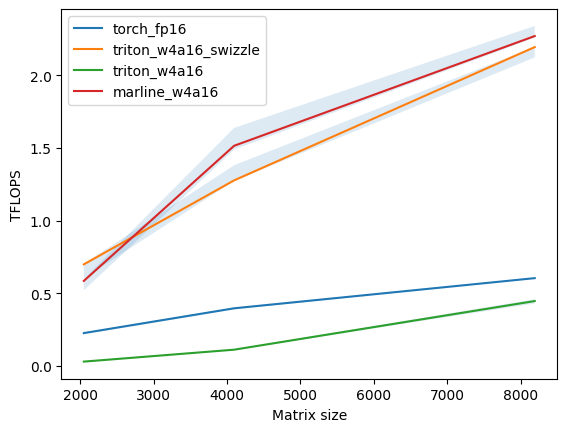

In [14]:
BS = 1
# sizes = [1024, 2048, 4096, 8192, 16384]
sizes = [2048, 4096, 8192]

configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["K", "M", "N"],  # Argument names to use as an x-axis for the plot
        # x_vals=[3 * (size,) for size in sizes],
        x_vals=[(size, BS, size) for size in sizes],
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals=[
            "torch_fp16",
            "triton_w4a16_swizzle",
            # "triton_w4a8_swizzle",
            # "triton_w4a16_lut",
            "triton_w4a16",
            # "triton_w2a16_swizzle",
            "marline_w4a16",
            # "ibm_w4a16_k4"
            ],
        line_names=[
            "torch_fp16",
            "triton_w4a16_swizzle",
            # "triton_w4a8_swizzle",
            # "triton_w4a16_lut",
            "triton_w4a16",
            # "triton_w4a16_swizzle",
            # "triton_w2a16_swizzle",
            "marline_w4a16",
            # "ibm_w4a16_k4"
            ],
        ylabel="TFLOPS",  # Label name for the y-axis
        xlabel="Matrix size",
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))


@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K)
    y_int8 = torch.randint(-128, 128, (M, K), dtype=torch.int8, device="cuda")
    
    x_compressed = torch.randint(-2**31, 2**31, (K // 8, N), dtype=torch.int32, device="cuda")
    
    # decompress
    shifter = torch.arange(0, 8, device="cuda") * 4
    x_decompressed = (x_compressed[:, None, :] >> shifter[None, :, None]) & 0xF
    x_decompressed = (x_decompressed - 0x8).reshape(K, N).to(torch.float16).contiguous()
    
    # swizzled
    x_compressed_swizzle_4bit = torch.randint(-2**31, 2**31, (K // 16, N * 2), dtype=torch.int32, device="cuda")
    x_compressed_swizzle_2bit = torch.randint(-2**31, 2**31, (K // 16, N), dtype=torch.int32, device="cuda")
    # x_compressed_swizzle_4bit_transposed = torch.randint(-2**31, 2**31, (N * 2, K // 16), dtype=torch.int32, device="cuda").T
    
    # lut
    # x_compressed_lut = torch.randint(0, 2**32, (K // 8, N), dtype=torch.uint32, device="cuda")
    # lut = torch.randn(16, dtype=torch.float16).cuda()

    # # marline
    _, x_compressed_marline, scales_marline = gen_quant4(K, N, groupsize=-1)
    
    # # imb kernel
    # b, zeros, scales = get_ibm_quant_params(K, N, groupsize=128)


    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp16":
        print(f"\n[M x K x N]: [{M} x {K} x {N}]")
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y_fp16, x_decompressed), quantiles=quantiles)
    
    if provider == "triton_w4a16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_w4a16(y_fp16, x_compressed), quantiles=quantiles)
        print("matmul_kernel_w4a16:", matmul_kernel_w4a16.best_config)
    
    if provider == "triton_w4a16_lut":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_w4a16_lut(y_fp16, x_compressed, lut), quantiles=quantiles)
        print("matmul_kernel_w4a16_lut:", matmul_kernel_w4a16_lut.best_config)
    
    if provider == "triton_w2a16_swizzle":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_w2a16_swizzle(y_fp16, x_compressed_swizzle_2bit), quantiles=quantiles)
        print("matmul_kernel_w2a16_swizzle:", matmul_kernel_w2a16_swizzle.best_config)
    
    if provider == "triton_w4a8_swizzle":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_w4a8_swizzle(y_int8, x_compressed_swizzle_4bit), quantiles=quantiles)
        print("matmul_kernel_w4a8_swizzle:", matmul_kernel_w4a8_swizzle.best_config)

    if provider == "triton_w4a16_swizzle":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_w4a16_swizzle(y_fp16, x_compressed_swizzle_4bit), quantiles=quantiles)
        print("matmul_kernel_w4a16_swizzle:", matmul_kernel_w4a16_swizzle.best_config)

    if provider == "marline_w4a16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: marline_matmul(y_fp16, x_compressed_marline, scales_marline), quantiles=quantiles)
    
    if provider == "ibm_w4a16_k4":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul_split_k(y_fp16, b, scales, zeros, split_k=4), quantiles=quantiles)

    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=False, print_data=True)

In [15]:
# import numpy as np
# import torch

# def _get_perms():
#     perm = []
#     for i in range(32):
#         perm1 = []
#         col = i // 4
#         for block in [0, 1]:
#             for row in [
#                 2 * (i % 4),
#                 2 * (i % 4) + 1,
#                 2 * (i % 4 + 4),
#                 2 * (i % 4 + 4) + 1
#             ]:
#                 perm1.append(16 * row + col + 8 * block)
#         for j in range(4):
#             perm.extend([p + 256 * j for p in perm1])

#     perm = np.array(perm)
#     interleave = np.array([0, 2, 4, 6, 1, 3, 5, 7])
#     perm = perm.reshape((-1, 8))[:, interleave].ravel()
#     perm = torch.from_numpy(perm)
#     scale_perm = []
#     for i in range(8):
#         scale_perm.extend([i + 8 * j for j in range(8)])
#     scale_perm_single = []
#     for i in range(4):
#         scale_perm_single.extend([2 * i + j for j in [0, 1, 8, 9, 16, 17, 24, 25]])
#     return perm, scale_perm, scale_perm_single

# _perm, _scale_perm, _scale_perm_single = _get_perms()

# print(_perm[:256])